In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## 1. Data Loading

In [2]:
# Import the csv with co-ordinates of bounding boxes

bb_df = pd.read_csv("/home/rb/anaconda2/bin/Project/nexet_2017/train_boxes.csv")

Consider only the largest bounding box corresponding to given image

In [3]:
bb_df['Area'] = (bb_df['x1']-bb_df['x0'])*(bb_df['y1']-bb_df['y0'])
max_ind = bb_df.groupby(['image_filename'])['Area'].idxmax()
bb_df = bb_df.loc[max_ind,:]
bb_df.drop('Area',axis= 1, inplace=True)
bb_df = bb_df.reset_index(drop=True)
bb_df = bb_df.head(1000)

In [4]:
#bb_df.to_csv("/home/rb/anaconda2/bin/Project/nexet_2017/train_boxes3.csv", index = False)

We have the top left and bottom right co-ordinates of the bounding boxes. We will use these to get co-ordinates of all edges of the bounding box. Then we try to get all the bounding box co-ords and image labels for a randomly selected image

In [5]:
# S is the size of grid. S=10 implies 10x10 grid
S = 10

# B is the number of bounding boxes per cell
B = 2

xi and yi are the centers of the bounding boxes
w and h are the width and height of bounding boxes

In [6]:
bb_df['w'] = bb_df['x1'] - bb_df['x0']
bb_df['h'] = bb_df['y1'] - bb_df['y0']
bb_df['xi'] = bb_df['x0'] + bb_df['w']/2
bb_df['yi'] = bb_df['y0'] + bb_df['h']/2
#bb_df.drop(['x3','y3','x4','y4'], axis = 1, inplace=True)

# Create dummy variables for the labels
dummy_labels = pd.get_dummies(bb_df.loc[:,'label'])
bb_df = bb_df.join(dummy_labels)

Rescale the x,y coordinates, widht and height  

In [7]:
bb_df[['w','xi','x0','x1']] = bb_df[['w','xi','x0','x1']]/1281
bb_df[['h','yi','y0','y1']] = bb_df[['h','yi','y0','y1']]/721

Create target matrix

In [8]:
for i in range(bb_df.shape[0]):
    
    # x_grid is the x-values in which the object lies
    x_grid = np.array(list(range(int(bb_df.loc[i,'x0']*100//S),int(bb_df.loc[i,'x1']*100//S+1))))
    
    # y_grid is the y-values in which the object lies
    y_grid = np.array(list(range(int(bb_df.loc[i,'y0']*100//S),int(bb_df.loc[i,'y1']*100//S+1))))
    
    # Grid is an array of size 15*10*10
    grid = np.zeros((5*B+5,S,S))
    
    # If grid cell contains object, make grid cell 1
    grid[:,x_grid.reshape(-1,1),y_grid] = 1

    # bb_vector contains confidence, xi, yi, h and w
    bb_vector = np.array(bb_df.loc[i,'confidence':'yi'])
    
    # Label vector contains 5 labels - bus, car, pickup-truck, truck and van
    label_vector = np.array(bb_df.loc[i,'bus':'van'])

    # target vector is a 15 length vector
    target_vector = np.append(bb_vector, np.append(bb_vector, label_vector))

    # target_matrix_temp is a 15x10x10 matrix with target vector for grid cells which contain the object
    target_matrix_temp = (grid.transpose(1,2,0)*target_vector).transpose(2,0,1)
    target_matrix_temp = target_matrix_temp[newaxis,:,:,:]
    
    # Store all target_matrix_temp (each corresponds to 1 image) into a 4d matrix
    if i==0:
        target_matrix = target_matrix_temp
    else:   
        target_matrix = np.append(target_matrix,target_matrix_temp, axis= 0)   
    if i%100==1:
        print(i)

1
101
201
301
401
501
601
701
801
901


DataLoader class. Refer http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [9]:
class CarsLoader_target(Dataset):
    
    def __init__(self, csv_file, root_dir, target_matrix, transform = None):
        self.bb_df = pd.read_csv(str(root_dir) + "/" + str(csv_file))
        cols = ['image_filename','x0','y0','x1','y1','label']
        self.bb_df = self.bb_df[cols]
        self.target_matrix = target_matrix
        self.root_dir = root_dir
        self.transform = transform
        
        
    def __len__(self):
        return len(self.bb_df)
    
    def __getitem__(self, idx):
        img_name = self.bb_df.ix[idx,0]
        img_loc = str(self.root_dir) + str(img_name)
        image = io.imread(img_loc)
        target = target_matrix[idx,:,:,:]        
        sample = {'image' : image, 'target': target}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [10]:
class CarsLoader(Dataset):
    
    def __init__(self, csv_file, root_dir, transform = None):
        self.bb_df = pd.read_csv(str(root_dir) + "/" + str(csv_file))
        cols = ['image_filename','x0','y0','x1','y1','label']
        self.bb_df = self.bb_df[cols]
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.bb_df)
    
    def __getitem__(self, idx):
        img_name = self.bb_df.ix[idx,0]
        img_loc = str(self.root_dir) + str(img_name)
        image = io.imread(img_loc)
        boundingboxes = self.bb_df.loc[self.bb_df.loc[:,'image_filename']==img_name,'x0':'y1'].as_matrix()
        labels = self.bb_df.loc[self.bb_df.loc[:,'image_filename']==img_name,'label']
        
        label_mapping = {'van':1, 'car':2, 'truck':3, 'bus':4, 'pickup_truck':5}
        labels = labels.map(label_mapping).as_matrix()
        
        sample = {'image' : image, 'boundingboxes': boundingboxes, 'labels' : labels}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

class FullTrainingDataset(torch.utils.data.Dataset):
    def init(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
#        assert len(full_ds)>=offset+length, Exception(“Parent Dataset not long enough”)
        super(FullTrainingDataset, self).init()

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        return self.full_ds[i+self.offset]

# Create train-test split
def trainTestSplit(dataset, val_share=0.7):
    val_offset = int(len(dataset)*(1-val_share))
    return  FullTrainingDataset(dataset, 0, val_offset), FullTrainingDataset(dataset, val_offset, len(dataset)-val_offset)

In [11]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'target': torch.from_numpy(target.astype('float'))}

class Flatten(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, boundingboxes, labels = sample['image'], sample['boundingboxes'], sample['labels']
        image = image.contiguous().view(-1)
        return {'image': image,
                'target': target}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, target = sample['image'], sample['target']

        h, w = image.shape[:2]

        new_h, new_w = self.output_size, self.output_size

        image = transform.resize(image, (new_h, new_w))
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        
        return {'image': image,
                'target': target}

In [12]:
# Use carsloader to convert the image dataset into a dataloader


imgTransform = transforms.Compose([Rescale(256),ToTensor()])
carsdataset = CarsLoader_target(csv_file='train_boxes3.csv', root_dir= '/home/rb/anaconda2/bin/Project/nexet_2017/',
                        target_matrix = target_matrix, transform = imgTransform)
#carsdataset = CarsLoader(csv_file='train_boxes2.csv', root_dir= '/home/rb/anaconda2/bin/Project/nexet_2017/',
#                         transform=transforms.Compose([ToTensor()]))
trainLoader = torch.utils.data.DataLoader(carsdataset, batch_size = 50, shuffle = True, num_workers = 4)

In [13]:
for i in range(len(carsdataset)):
    sample = carsdataset[i]
    print(i, sample['image'].size(), sample['target'].size())
    if i == 3:
        break

0 torch.Size([3, 256, 256]) torch.Size([15, 10, 10])
1 torch.Size([3, 256, 256]) torch.Size([15, 10, 10])
2 torch.Size([3, 256, 256]) torch.Size([15, 10, 10])
3 torch.Size([3, 256, 256]) torch.Size([15, 10, 10])


In [14]:
for i, index in enumerate(trainLoader):
    print(i, index['image'].size(), index['target'].size())
    break

0 torch.Size([50, 3, 256, 256]) torch.Size([50, 15, 10, 10])


## 2. Modelling

In [15]:
loss_df = pd.DataFrame(columns = ['Type','Epoch','Loss'])

In [16]:
from tqdm import tqdm as tqdm 

def train_model(network, criterion, optimizer, trainLoader, n_epochs = 10):
    
    iter_x = 0
    
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, item) in enumerate(trainLoader):
            
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(item['image'].type(torch.ByteTensor), requires_grad = True)
            labels = Variable(item['target'].type(torch.FloatTensor), requires_grad = False)

            # Forward pass:
            outputs = network(inputs.float())
            loss = criterion(outputs, labels)
            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            t.set_postfix(loss = cum_loss / (1 + i))
            
#        print("epoch:", epoch)
                
        loss_df.loc[iter_x,'Type'] = "Train"
        loss_df.loc[iter_x,'Epoch'] = epoch + 1
        loss_df.loc[iter_x,'Loss'] = cum_loss / (i + 1)

        iter_x +=1

# # Validation    

#         correct = 0.0
#         cum_loss = 0.0
#         counter = 0
#         t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
#         network.eval()  # This is important to call before evaluating!
#         for (i, (inputs, labels)) in enumerate(t):

#             # Wrap inputs, and targets into torch.autograd.Variable types.
#             inputs = Variable(inputs, requires_grad = True)
#             labels = Variable(labels, requires_grad = False)

#             # Forward pass:
#             outputs = network(inputs)
#             loss = criterion(outputs, labels)

#             # logging information.
#             cum_loss += loss.data[0]
#             max_scores, max_labels = outputs.data.max(1)
#             correct += (max_labels == labels.data).sum()
#             counter += inputs.size(0)
#             t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
#             loss_df.loc[iter_x,'Type'] = "Validation"

#         loss_df.loc[iter_x,'Epoch'] = epoch + 1
#         loss_df.loc[iter_x,'Loss'] = cum_loss / (i + 1)

#         accuracy_df.loc[iter_x,'Type'] = "Validation"
#         accuracy_df.loc[iter_x,'Epoch'] = epoch + 1
#         accuracy_df.loc[iter_x,'Accuracy'] = 100 * correct / counter

#         iter_x +=1

In [17]:
class nn_YOLOLoss(nn.Module): 

    def forward(self, inputs, labels):

        lambda_coord = 5
        lambda_noobj = 0.5

#         inputs = target_matrix + 3
#         labels = target_matrix

#         inputs = torch.FloatTensor(inputs.astype('float'))
#         labels = torch.FloatTensor(labels.astype('float'))

        filled_labels = labels/labels
        unfilled_labels = filled_labels!=filled_labels
        filled_labels = filled_labels==filled_labels

        # x,y loss
        xy1_diff = inputs[:,3:4,:,:] - labels[:,3:4,:,:]
        xy1_loss = (torch.mul(xy1_diff,xy1_diff)*filled_labels[:,3:4,:,:].float()).mean()

        xy2_diff = inputs[:,8:9,:,:] - labels[:,8:9,:,:]
        xy2_loss = (torch.mul(xy1_diff,xy1_diff)*filled_labels[:,8:9,:,:].float()).mean()

        total_xy_loss = lambda_coord*(xy1_loss+xy2_loss)

        # w,h loss
        
        wh1_diff = torch.sqrt(inputs[:,1:2,:,:].abs()) - torch.sqrt(labels[:,1:2,:,:].abs())
        wh1_loss = (torch.mul(wh1_diff,wh1_diff)*filled_labels[:,3:4,:,:].float()).mean()

        wh2_diff = torch.sqrt(inputs[:,6:7,:,:].abs()) - torch.sqrt(labels[:,6:7,:,:].abs())
        wh2_loss = (torch.mul(wh2_diff,wh2_diff)*filled_labels[:,6:7,:,:].float()).mean()

        total_wh_loss = lambda_coord*(wh1_loss+wh2_loss)

        # label loss
        label_diff = inputs[:,10:,:,:] - labels[:,10:,:,:]
        label_loss = (torch.mul(label_diff,label_diff)*filled_labels[:,10:,:,:].float()).mean()

        noobj_label_loss = (torch.mul(label_diff,label_diff)*unfilled_labels[:,10:,:,:].float()).mean()

        total_label_loss = label_loss + lambda_noobj*noobj_label_loss

        total_loss = total_xy_loss + total_wh_loss + total_label_loss  

        return(total_loss)

In [18]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 15, 5)
        self.conv2 = nn.Conv2d(15,25,7, stride=2)
        self.conv3 = nn.Conv2d(25,60,7)
        self.conv4 = nn.Conv2d(60, 120, 3)
      
        # Linear layers.
        self.fc1 = nn.Linear(120*10*10, 4800)
        self.fc2 = nn.Linear(4800, 2400)
        self.fc3 = nn.Linear(2400, 15*10*10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv3(out))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv4(out))
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))
        out = out.view(50,15,10,10)
        
        return out     

In [19]:
learningRate = 0.01
        
# Definition of our network.
network = LeNet()

# Criterion
criterion = nn.MSELoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate, momentum=0.8)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, n_epochs = 4)                                

Training epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/20 [01:28<?, ?it/s, loss=0.239]

Training epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]


Training epoch 2:   0%|          | 0/20 [00:12<?, ?it/s, loss=0.239]

Training epoch 2:   0%|          | 0/20 [00:18<?, ?it/s, loss=0.24]

Training epoch 2:   0%|          | 0/20 [00:23<?, ?it/s, loss=0.24]

Training epoch 2:   0%|          | 0/20 [00:27<?, ?it/s, loss=0.24]

Training epoch 2:   0%|          | 0/20 [00:31<?, ?it/s, loss=0.24]

Training epoch 2:   0%|          | 0/20 [00:36<?, ?it/s, loss=0.239]

Training epoch 2:   0%|          | 0/20 [00:40<?, ?it/s, loss=0.239]

Training epoch 2:   0%|          | 0/20 [00:44<?, ?it/s, loss=0.239]

Training epoch 2:   0%|          | 0/20 [00:48<?, ?it/s, loss=0.239]

Training epoch 2:   0%|          | 0/20 [00:52<?, ?it/s, loss=0.239]

Training epoch 2:   0%|          | 0/20 [00:57<?, ?it/s, loss=0.239]

Training epoch 2:   0%|          | 0/20 [01:01<

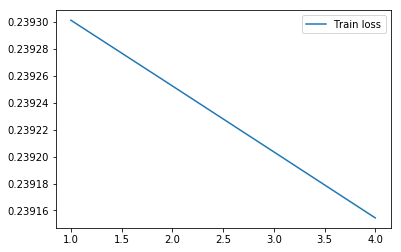

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
# print(loss_df, accuracy_df)
trainloss_plot = plt.plot(loss_df.loc[loss_df['Type']=="Train", 'Epoch'],loss_df.loc[loss_df['Type']=="Train", 'Loss'], label = 'Train loss')
plt.legend(loc = 'upper right')
plt.show()

In [21]:
def show_bounding_box(image_var, img_bb):

    plt.imshow(image_var.numpy().transpose(1, 2, 0))
    for i in img_bb.index:
        plt.plot(img_bb.loc[i,['x0','x3']], img_bb.loc[i,['y0','y3']], color = "blue")
        plt.plot(img_bb.loc[i,['x1','x4']], img_bb.loc[i,['y1','y4']], color = "blue")
        plt.plot(img_bb.loc[i,['x0','x4']], img_bb.loc[i,['y0','y4']], color = "blue")
        plt.plot(img_bb.loc[i,['x1','x3']], img_bb.loc[i,['y1','y3']], color = "blue")

In [25]:
def get_batch_pred(trainLoader):
    for i,item in enumerate(trainLoader):
        test_batch = item['image']
        break
    
    test_batch_var = Variable(test_batch.type(torch.FloatTensor))
    
    # Make prediction for test_batch_var
    batch_labels = network(test_batch_var.float())
    return batch_labels, test_batch

def convert_batch_labels(i, batch_labels, test_batch):
    batch_labels = batch_labels.data.numpy()

    test_img = test_batch[i,:,:,:]
    img_labels = batch_labels[i,:,:,:]

    high_conf_box = img_labels[[0,5],:,:].argmax()

    high_conf_b = high_conf_box//100
    high_conf_y_grid= (high_conf_box-high_conf_b*100)//10
    high_conf_x_grid = high_conf_box%10

    print(img_labels[:,high_conf_x_grid,high_conf_y_grid])
    pred_w = abs(img_labels[high_conf_b*5+1 ,high_conf_x_grid, high_conf_y_grid])*256
    pred_h = abs(img_labels[high_conf_b*5+2 ,high_conf_x_grid, high_conf_y_grid])*256
    pred_xi = max(img_labels[high_conf_b*5+3 ,high_conf_x_grid, high_conf_y_grid],0)*256
    pred_yi = max(img_labels[high_conf_b*5+4 ,high_conf_x_grid, high_conf_y_grid],0)*256
    pred_x0 = max(pred_xi-pred_w/2,0)
    pred_x1 = min(pred_xi+pred_w/2,256)

    pred_y0 = max(pred_yi-pred_h/2,0)
    pred_y1 = min(pred_xi+pred_h/2,256)

    pred_x3 = pred_x1
    pred_y3 = pred_y0

    pred_x4 = pred_x0
    pred_y4 = pred_y1

    img_bb = pd.DataFrame({'x0':pred_x0, 'y0':pred_y0,
                           'x1':pred_x1, 'y1':pred_y1,
                           'x3':pred_x3, 'y3':pred_y3,
                           'x4':pred_x4, 'y4':pred_y4},index=[0])
    show_bounding_box(test_img, img_bb)

In [26]:
batch_labels,test_batch = get_batch_pred(trainLoader)

[ 0.50540012  0.50420117  0.49585715  0.5034821   0.5002507   0.49630427
  0.50368017  0.50077522  0.5034343   0.49556148  0.50145406  0.50129622
  0.49683598  0.50090975  0.50100845]


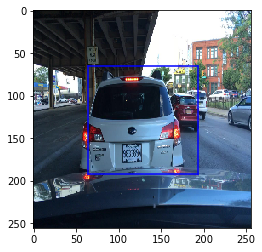

In [34]:
convert_batch_labels(3,batch_labels, test_batch)